#### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

#### LSTM parameters

- n_signals: signals fed into model for each event (i.e. for input signals: [$I_{a}$, $I_{b}$, $I_{c}$] -> n_signals = 3).
- N: window size. For 3840Hz sampling frequency and a 0.016ms window (containing one cycle of a 60Hz wave), N = 64.
$$ N = fs/f_{fundamental}$$
- target_size
    - target_size = 1:
        - Binary Classification: One output treated as probability of belonging to one class or the other (E.g. No-Fault: 0 /Fault: 1)
    - target_size > 1:
        - Multiclass: Multiple exclusive classes. Class with higher score represents predicted class. The sum of scores (using softmax) always sums 1. (E.g. [No-fault, Fault, Caps], a output of values [0.07, 0.91, 0.2] represents a Fault class prediction)
        - Multilabel: Multiple classes that are not mutually exclusive.

In [2]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64
target_size = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


#### Model Creation

(Hablar un poco de la arquitectura del modelo)

In [ ]:
# Model Creation

class FaultDetector(nn.Module):
    """Some Information about FaultDetector"""
    def __init__(self, N, hidden_dim, target_size):
        super(FaultDetector, self).__init__()
        self.sequential = nn.Sequential(
            nn.LSTM(N, hidden_dim, batch_first=True),
            nn.Linear(hidden_dim, target_size)
        )
    def forward(self, x):
        z = self.sequential(x)
        return torch.sigmoid(z)

#### Dataset Class 

In [ ]:
class FaultDataset(torch.utils.data.Dataset):
    """Some Information about FaultDataset"""
    def __init__(self):
        super(FaultDataset, self).__init__()

    def __getitem__(self, index):
        return 

    def __len__(self):
        return 

C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/septDataBaseCSV/Fallas/Fault01_B112_RF40.csv
Se seleccionó Fault01_B112_RF40
768


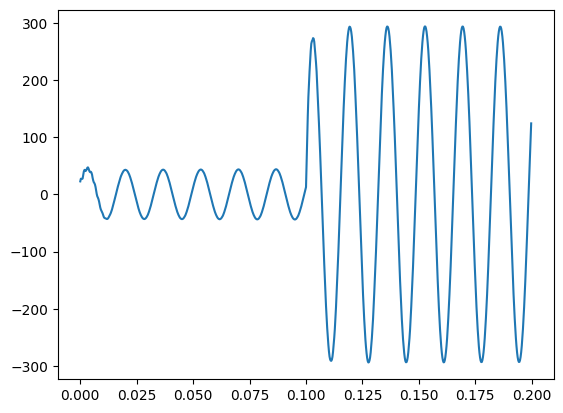

In [50]:
# Dataset Parameters
fs = 3840
N = 64
m = 2200

from utils.signalload import CSV_pandas
from utils.preprocess import windows_creator

signal_name = "I: X0024A-R1A"
signals = CSV_pandas()
signal, t, _ = signals.load_data("I: X0024A-R1A")
signal_len = len(signal)
plot_len = signal_len + 0

plt.plot(t[:plot_len], signal[:plot_len])

windows_creator(N, signals,)

In [21]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [ ]:
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

In [ ]:
# Save the Model
# torch.save(model.state_dict(), './models/LSTMHarmonic_weights.pth')
model.load_state_dict(torch.load('./models/LSTMHarmonic_weights.pth'))

In [ ]:
dataiter = iter(val_dataloader)
signal, labels = next(dataiter)
t = np.linspace(0, N / fs, N)
print(labels[1:10])
print(signal.shape)
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model(signal[1:10].to(device))
print(torch.round(x))